#### Customer Segmentation (Clustering - K-Means) 

<b>Objective: </B>
```
• Categorize Amazon customers into distinct groups based on spending patterns, purchase 
frequency, and loyalty scores. 
• Identify high-value, occasional, and low-value customers for targeted promotions.
```
<b>Method:</B>
```
• Use K-Means Clustering to segment customers into groups based on: 
• Total purchase amount 
• Number of orders 
• Loyalty score 
```
Industry Application:</B> 
• Helps Amazon personalize recommendations and promotions for different customer segments. 
• Enables dynamic pricing strategies based on customer type.

In [ ]:
# Code implementation:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import openpyxl
import fastparquet
from pandas.plotting import (
    table, andrews_curves, autocorrelation_plot, bootstrap_plot,
    lag_plot, parallel_coordinates, radviz, scatter_matrix)
import os
from sklearn.impute import SimpleImputer

In [69]:
# Load the Amazon Customers dataset
df = pd.read_parquet("featured_df.parquet")
k_df = df.copy()

In [70]:
# mapping dict
mapping = {'New': 1, 'Regular': 2, 'VIP': 3}

# Apply mapping
k_df['Customer_Segment_Recomputed'] = k_df['Customer_Segment_Recomputed'].map(mapping)
k_df['Customer_Segment_Recomputed'].unique()

array([1, 2, 3])

In [61]:
# from sklearn.preprocessing import LabelEncoder

# arr = np.array(['New', 'Regular', 'VIP'])
# encoder = LabelEncoder()
# encoded = encoder.fit_transform(arr)

# print(encoded)  # [0 1 2 1 0]
# print(encoder.classes_)  # ['New' 'Regular' 'VIP']


[0 1 2]
['New' 'Regular' 'VIP']


In [71]:
# Extract the relevant columns
X = k_df[['clv_latest','Customer_Segment_Recomputed']].values

In [109]:
c1 = df.columns.sort_values().to_list()
print(c1)

['Age', 'CID_PID', 'CID_PID_CH', 'Customer_ID', 'Customer_Lifetime_Value', 'Customer_Name', 'Customer_Segment', 'Customer_Segment_Recomputed', 'Discount_Applied', 'Feedback_Comments', 'Gender', 'Location', 'Loyalty_Score', 'Payment_Method', 'Preferred_Shopping_Channel', 'Product_Category', 'Product_ID', 'Purchase_Amount', 'Purchase_Date', 'Rating', 'Return_Status', '_merge', 'avg_purchase', 'avg_rating', 'both_share', 'cluster', 'clv_latest', 'clv_mean', 'discount_rate', 'frequency', 'id_name_meerge', 'instore_share', 'is_both', 'is_discount', 'is_instore', 'is_online', 'is_return', 'last_purchase', 'log1p_Customer_Lifetime_Value', 'log1p_Loyalty_Score', 'log1p_Purchase_Amount', 'loyalty_avg', 'loyalty_score_engineered', 'monetary', 'online_share', 'recency_days', 'return_rate']


In [79]:
k_df['clv_latest'].unique()

array([3673.71274713, 2103.0603881 , 2202.63324234, ..., 5273.58507943,
       3831.27493473, 4752.3401184 ], shape=(1643,))

In [80]:
k_df['Customer_Segment_Recomputed'].unique()

array([1, 2, 3])

In [75]:
# Determine optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

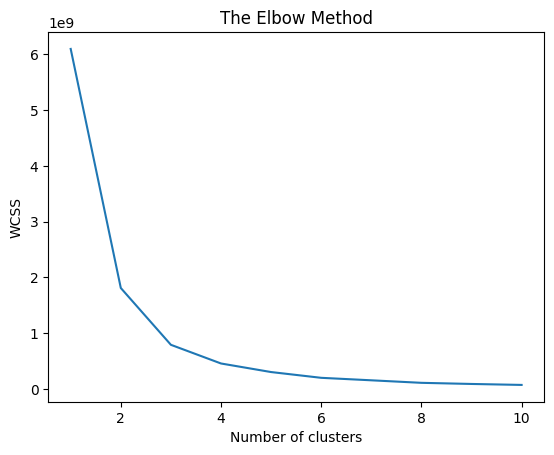

In [76]:
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig("Elbow Method.png")
plt.show()

In [77]:
# Train K-means model based on the Elbow point (for this exercise, assume it's 5)
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

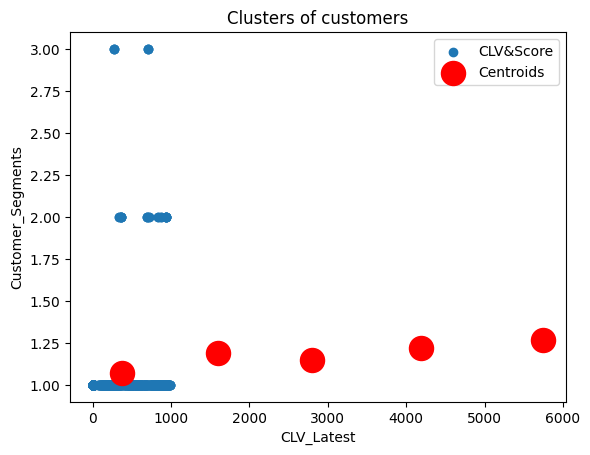

In [81]:
# Visualize the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], label='CLV&Score')
# ... (repeat for other clusters)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Clusters of customers')
plt.xlabel('CLV_Latest')
plt.ylabel('Customer_Segments')
plt.legend()
plt.savefig("Cluster 1.png")
plt.show()

In [83]:
k_df.columns.to_list()

['Customer_ID',
 'Customer_Name',
 'Age',
 'Gender',
 'Location',
 'Product_Category',
 'Product_ID',
 'Purchase_Date',
 'Purchase_Amount',
 'Payment_Method',
 'Rating',
 'Feedback_Comments',
 'Customer_Lifetime_Value',
 'Loyalty_Score',
 'Discount_Applied',
 'Return_Status',
 'Customer_Segment',
 'Preferred_Shopping_Channel',
 'id_name_meerge',
 'CID_PID_CH',
 'CID_PID',
 'log1p_Purchase_Amount',
 'log1p_Customer_Lifetime_Value',
 'log1p_Loyalty_Score',
 'is_discount',
 'is_return',
 'is_online',
 'is_instore',
 'is_both',
 'last_purchase',
 'frequency',
 'monetary',
 'avg_purchase',
 'avg_rating',
 'discount_rate',
 'return_rate',
 'online_share',
 'instore_share',
 'both_share',
 'loyalty_avg',
 'clv_latest',
 'clv_mean',
 'recency_days',
 'loyalty_score_engineered',
 'Customer_Segment_Recomputed',
 '_merge']

In [89]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_features = ['monetary','frequency','loyalty_score_engineered']
X_cluster = df[cluster_features].copy()

# Impute + scale (standard practice for k-means)
preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
Xc = preproc.fit_transform(X_cluster)

# Evaluate k in 2..8 (you can fix k=3 if the rubric demands exactly 3 segments)
inertias, sils = {}, {}
ks = range(2, 9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xc)
    inertias[k] = km.inertia_
    sils[k] = silhouette_score(Xc, labels)

# Plot elbow & silhouette diagnostics
plt.figure(figsize=(6,4))
plt.plot(list(inertias.keys()), list(inertias.values()), marker='o')
plt.title('Elbow Curve (K-Means)')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.tight_layout(); plt.savefig('elbow_curve.png', dpi=200); plt.close()

plt.figure(figsize=(6,4))
plt.plot(list(sils.keys()), list(sils.values()), marker='o', color='darkorange')
plt.title('Silhouette Scores (K-Means)')
plt.xlabel('k'); plt.ylabel('Silhouette')
plt.tight_layout(); plt.savefig('silhouette_scores.png', dpi=200); plt.close()

# Choose k by max silhouette (tie-breaker: smaller k)
best_k = max(sils, key=lambda k: (sils[k], -k))
print("Chosen k:", best_k, "Silhouette:", sils[best_k])

# Fit final model
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km_final.fit_predict(Xc)
df['cluster'] = labels


Chosen k: 2 Silhouette: 0.6755170130101364


In [94]:
import numpy as np
import pandas as pd
cust_df = df.copy()
# Cluster centers (standardized space)
centers_std = km_final.cluster_centers_

# Composite score weights
w = np.array([0.5, 0.3, 0.2])  # monetary, frequency, loyalty
cluster_scores = centers_std.dot(w)

# Map each cluster to a segment label by score ranking
sorted_idx = np.argsort(-cluster_scores)
label_map = {}
for i, cl in enumerate(sorted_idx):
    if i == 0:
        label_map[cl] = 'High-Value'
    elif i == len(sorted_idx)-1:
        label_map[cl] = 'Low-Value'
    else:
        label_map[cl] = 'Occasional'

cust_df['segment_label'] = cust_df['cluster'].map(label_map)

# Profile clusters in original feature space
cluster_profile = cust_df.groupby('cluster')[cluster_features].mean().round(2)
cluster_profile['composite_score_std'] = pd.Series(cluster_scores, index=cluster_profile.index).round(4)
cluster_profile['segment_label'] = cluster_profile.index.map(label_map)


print("Cluster profile:\n", cluster_profile)
print("Label distribution:\n", cust_df['segment_label'].value_counts())


Cluster profile:
          monetary  frequency  loyalty_score_engineered  composite_score_std  \
cluster                                                                       
0          252.31       1.03                     13.64              -0.3371   
1          595.00       2.21                     46.06               1.6754   

        segment_label  
cluster                
0           Low-Value  
1          High-Value  
Label distribution:
 segment_label
Low-Value     1665
High-Value     335
Name: count, dtype: int64


In [99]:
from sklearn.decomposition import PCA

Xc_pca = PCA(n_components=2, random_state=42).fit_transform(Xc)
viz = pd.DataFrame({
    'pc1': Xc_pca[:,0],
    'pc2': Xc_pca[:,1],
    'segment_label': cust_df['segment_label'].values
}, index=cust_df.index)

plt.figure(figsize=(4,4))
for seg, color in [('High-Value','tab:red'), ('Occasional','tab:blue'), ('Low-Value','tab:green')]:
    mask = viz['segment_label'] == seg
    plt.scatter(viz.loc[mask,'pc1'], viz.loc[mask,'pc2'],
                s=25, alpha=0.7, label=seg, c=color)
plt.title('Customer Segments (PCA 2D) — Monetary, Frequency, Loyalty')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()
plt.tight_layout(); plt.savefig('cluster_scatter_pca.png', dpi=200); plt.close()

print("Saved plots: elbow_curve.png, silhouette_scores.png, cluster_scatter_pca.png")

Saved plots: elbow_curve.png, silhouette_scores.png, cluster_scatter_pca.png


# Objective 2 Linear Regression for CLV

2️⃣ Predicting Customer Lifetime Value (Regression - Linear Regression)
<b>Objective:</b>
```
• Estimate the future revenue Amazon can generate from each customer.
• Identify high-CLV customers and offer exclusive deals to increase retention.
```
<b>Method:</b>
```
• Train a Linear Regression model to predict CLV based on: 
• Age, past purchases, discount usage, payment method, and loyalty score.
```
<b>Industry Application:</b>
```
• Helps Amazon in predictive marketing and resource allocation. 
• Enables cost-efficient retention strategies. 
```

In [100]:
# Datatypes
if 'Purchase_Date' in df.columns:
    df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')

# We will build a **customer-level** frame (one row per Customer_ID), using the last row if multiple exist
if 'Customer_ID' not in df.columns:
    raise ValueError("Customer_ID is required.")

cust_df = (df.sort_values('Purchase_Date' if 'Purchase_Date' in df.columns else 'Customer_ID')
             .groupby('Customer_ID')
             .tail(1)
             .set_index('Customer_ID'))

In [101]:
# ---- Target: CLV ----
# Prefer clv_mean -> clv_latest -> Customer_Lifetime_Value (consistent with earlier steps)
target_col = next((t for t in ['clv_mean', 'clv_latest', 'Customer_Lifetime_Value'] if t in cust_df.columns), None)
if target_col is None:
    raise ValueError("No CLV target found (clv_mean/clv_latest/Customer_Lifetime_Value).")

In [102]:
# ---- Features per assignment ----
# Age
# Past purchases → monetary (total spend), frequency (number of orders)
# Discount usage → discount_rate (mean of is_discount per customer)
# Payment method → Payment_Method (categorical)
# Loyalty score → loyalty_score_engineered (fallback to Loyalty_Score)
for c in ['Age','monetary','frequency','discount_rate','Loyalty_Score','loyalty_score_engineered']:
    if c in cust_df.columns:
        cust_df[c] = pd.to_numeric(cust_df[c], errors='coerce')

In [103]:
# Loyalty feature harmonization
cust_df['loyalty_feature'] = (
    cust_df['loyalty_score_engineered']
    if 'loyalty_score_engineered' in cust_df.columns
    else (cust_df['Loyalty_Score'] if 'Loyalty_Score' in cust_df.columns else np.nan)
)

In [104]:
# Payment method as categorical
if 'Payment_Method' not in cust_df.columns:
    # If missing at customer level, take most frequent payment method from transactions (optional)
    if set(['Customer_ID','Payment_Method']).issubset(df.columns):
        top_pm = (df.groupby('Customer_ID')['Payment_Method']
                    .agg(lambda s: s.mode().iat[0] if len(s.mode())>0 else s.iloc[-1]))
        cust_df['Payment_Method'] = top_pm
    else:
        cust_df['Payment_Method'] = 'Unknown'

In [105]:
# Build design matrix exactly as the assignment requires
feature_cols = ['Age', 'monetary', 'frequency', 'discount_rate', 'Payment_Method', 'loyalty_feature']

# Fill and sanity-check
X_full = cust_df[feature_cols].copy()
y_full = cust_df[target_col].copy()

print("Feature availability:\n", X_full.dtypes)
print("\nTarget:", target_col, "— non-null count:", y_full.notna().sum(), "of", y_full.shape[0])

Feature availability:
 Age                 float64
monetary            float64
frequency             int64
discount_rate       float64
Payment_Method     category
loyalty_feature       int64
dtype: object

Target: clv_mean — non-null count: 1800 of 1800


In [106]:
# Cell 1: Linear Regression training & evaluation

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split train/test
X = X_full
y = y_full

# Identify numeric vs categorical columns per assignment
num_features = ['Age', 'monetary', 'frequency', 'discount_rate', 'loyalty_feature']
cat_features = ['Payment_Method']

# Preprocessor:
# - Numeric: median impute + standardize
# - Categorical: most_frequent impute + one-hot (drop='first' for reference coding)
# 1st
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# 2ns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
#3rds
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'
)

# total
lin_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Fit
lin_pipe.fit(X_train, y_train)

# Predict & evaluate
y_pred = lin_pipe.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5        # compat across sklearn versions
r2   = r2_score(y_test, y_pred)

print("Linear Regression CLV Metrics:")
print({"mae": mae, "rmse": rmse, "r2": r2})


Linear Regression CLV Metrics:
{'mae': 833.5715195250917, 'rmse': 1185.9821275262555, 'r2': 0.504163135253556}


In [107]:
import joblib

# Save model
joblib.dump({
    'pipeline': lin_pipe,
    'features': feature_cols,
    'target': target_col,
    'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2}
}, 'clv_linear_model.pkl')

# Generate predictions for ALL customers (scoring)
clv_pred_all = lin_pipe.predict(X_full)
pred_df = cust_df[['Age','monetary','frequency','discount_rate','Payment_Method','loyalty_feature']].copy()
pred_df['clv_pred_linear'] = clv_pred_all
pred_df['clv_actual'] = y_full

# Save predictions
pred_df.to_parquet('clv_linear_predictions.parquet')
pred_df.to_pickle('clv_linear_predictions.pkl')

# Identify high-CLV customers (top decile by predicted CLV)
top_decile_cut = np.nanpercentile(pred_df['clv_pred_linear'], 90)
high_clv_customers = pred_df[pred_df['clv_pred_linear'] >= top_decile_cut].sort_values('clv_pred_linear', ascending=False)

# Save high-CLV list
high_clv_customers.reset_index().to_parquet('high_clv_customers_linear.parquet', index=False)
high_clv_customers.reset_index().to_pickle('high_clv_customers_linear.pkl')

print("Saved:")
print("- clv_linear_model.pkl")
print("- clv_linear_predictions.parquet / .pkl")
print("- high_clv_customers_linear.parquet / .pkl")
print("Top decile cutoff (pred CLV):", float(top_decile_cut))
print("High-CLV customer count:", high_clv_customers.shape[0])


Saved:
- clv_linear_model.pkl
- clv_linear_predictions.parquet / .pkl
- high_clv_customers_linear.parquet / .pkl
Top decile cutoff (pred CLV): 4045.1660336944647
High-CLV customer count: 180


``` python
Linear Regression CLV Metrics:
{'mae': 833.5715195250917, 'rmse': 1185.9821275262555, 'r2': 0.504163135253556}
Saved:
Top decile cutoff (pred CLV): 4045.1660336944647
High-CLV customer count: 180

```